<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Generative adversarial networks


В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !mkdir faces Большие картинки
# !unzip -q '/content/drive/MyDrive/faces_dataset_small.zip' "faces_dataset_small/*" -d 'faces'
# DATA_DIR = '/content/faces/'

In [ ]:
# import zipfile

# archive = zipfile.ZipFile('archive.zip')

# for file in archive.namelist():
#     if file.startswith('foo/'):
#         archive.extract(file, 'destination_path')

In [ ]:
!pip install -U --no-cache-dir gdown --pre
!gdown --id 1RpAjKLktZKIgVQjfpQRDQKDE4L5MsIV4 # Маленькие картинки 64 * 64 для увеличения скорости обучения
# !gdown --id 14Y0pv9oex8EmrhCOBXrMrx2OswjzoIsI
!unzip -q faces64c.zip && rm faces64c.zip
# !unzip -q faces512c.zip && rm faces512c.zip

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-3.13.0-cp37-none-any.whl size=9046 sha256=79b50b26c4e0806553f9da797c270f37321c4c8797e1d6e59629a5342e0a4405
  Stored in directory: /tmp/pip-ephem-wheel-cache-j_dwshqx/wheels/ba/fa/c5/12813d7496f34652c43a471e11a780e769889d06e34735c32e
Successfully built gdown
  Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4
Downloading...
From: https://drive.google.com/uc?id=1RpAjKLktZKIgVQjfpQRDQKDE4L5MsIV4
To: /content/faces64c.zip
22.8MB [00:00, 36.7MB/s]


In [ ]:
DATA_DIR = '/content/faces64c'

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения

In [ ]:
def get_dataloader(image_size, batch_size, stats):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  # TODO: resize images, convert them to tensors and build dataloader

  train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))
  return DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#TODO: build dataloader and transfer it to device
train_dl = get_dataloader(image_size, batch_size, stats)

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

train_dl = DeviceDataLoader(train_dl, device)  

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.cpu().detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

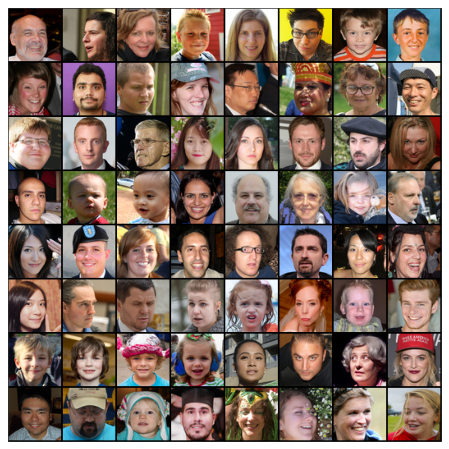

In [ ]:
show_batch(train_dl)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
# Image size: 64 * 64
discriminator = nn.Sequential( # in: 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True), # out: 64 x 32 x 32
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True), # out: 128 x 16 x 16
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True), # out: 256 x 8 x 8
    
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True), # out: 512 x 4 x 4
    
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False), # out: 1 x 1 x 1
    
    nn.Flatten(),
    nn.Sigmoid())

discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
# Image size: 64 * 64
generator = nn.Sequential( # in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True), # out: 512 x 4 x 4
    
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True), # out: 256 x 8 x 8
    
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True), # out: 128 x 16 x 16
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True), # out: 64 x 32 x 32
    
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh() # out: 3 x 64 x 64
)

generator = to_device(generator, device)

torch.Size([128, 3, 64, 64])


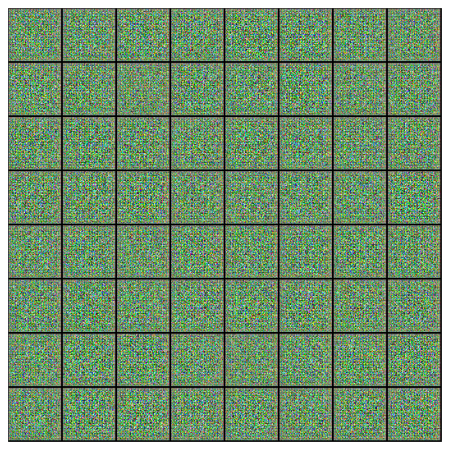

In [ ]:
# just for debug
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb.to(device))
print(fake_images.shape)
show_images(fake_images)

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)
fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
lr = 0.0001

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [ ]:
hist = []
def fit(model, criterion, epochs, lr, start_idx=1):
  # TODO: build optimizers and train your GAN
  model["discriminator"].train()
  model["generator"].train()
  torch.cuda.empty_cache()
  
  # Losses & scores
  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []
  
  # Create optimizers
  optimizer = {
      "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                        lr=lr, betas=(0.5, 0.999)),
      "generator": torch.optim.Adam(model["generator"].parameters(),
                                    lr=lr, betas=(0.5, 0.999))
  }
  
  for epoch in range(epochs):
      loss_d_per_epoch = []
      loss_g_per_epoch = []
      real_score_per_epoch = []
      fake_score_per_epoch = []
      for real_images, _ in tqdm(train_dl):
          # Train discriminator
          # Clear discriminator gradients
          optimizer["discriminator"].zero_grad()

          # Pass real images through discriminator
          real_preds = model["discriminator"](real_images)
          real_targets = torch.ones(real_images.size(0), 1, device=device)
          real_loss = criterion["discriminator"](real_preds, real_targets)
          cur_real_score = torch.mean(real_preds).item()
          
          # Generate fake images
          latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
          fake_images = model["generator"](latent)

          # Pass fake images through discriminator
          fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
          fake_preds = model["discriminator"](fake_images)
          fake_loss = criterion["discriminator"](fake_preds, fake_targets)
          cur_fake_score = torch.mean(fake_preds).item()

          real_score_per_epoch.append(cur_real_score)
          fake_score_per_epoch.append(cur_fake_score)

          # Update discriminator weights
          loss_d = real_loss + fake_loss
          loss_d.backward()
          optimizer["discriminator"].step()
          loss_d_per_epoch.append(loss_d.item())


          # Train generator
          # Clear generator gradients
          optimizer["generator"].zero_grad()
          
          # Generate fake images
          latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
          fake_images = model["generator"](latent)
          
          # Try to fool the discriminator
          preds = model["discriminator"](fake_images)
          targets = torch.ones(batch_size, 1, device=device)
          loss_g = criterion["generator"](preds, targets)
          
          # Update generator weights
          loss_g.backward()
          optimizer["generator"].step()
          loss_g_per_epoch.append(loss_g.item())
          
      # Record losses & scores
      losses_g.append(np.mean(loss_g_per_epoch))
      losses_d.append(np.mean(loss_d_per_epoch))
      real_scores.append(np.mean(real_score_per_epoch))
      fake_scores.append(np.mean(fake_score_per_epoch))

      hist.append((losses_g, losses_d, real_scores, fake_scores))
      
      # Log losses & scores (last batch)
      print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
          epoch+1, epochs, 
          losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
  
      # Save generated images
      if epoch == epochs - 1:
        save_samples(epoch+start_idx, fixed_latent, show=False)
      
  
  return losses_g, losses_d, real_scores, fake_scores

In [ ]:
# latent = torch.randn(batch_size, latent_size, 1, 1, device=device) # just for debug
# fake_images = model["generator"](latent)
# save_samples(90, latent, True)

In [ ]:
epochs = 200 # 200
history = fit(model, criterion, epochs, lr)

NameError: ignored

In [ ]:
# save model
torch.save(model["discriminator"].state_dict(), './discriminator.zip')
torch.save(model["generator"].state_dict(), './generator.zip')

In [ ]:
# load model
model['discriminator'].load_state_dict(torch.load('./discriminator.zip'))
model['generator'].load_state_dict(torch.load('./generator.zip'))
# model.to(device)

<All keys matched successfully>

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
generated_img = cv2.imread(f'./generated/generated-images-00{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

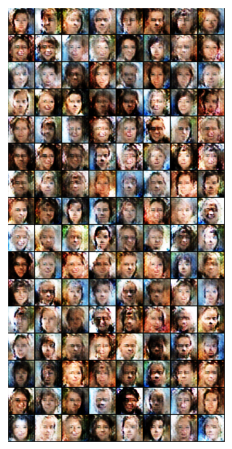

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

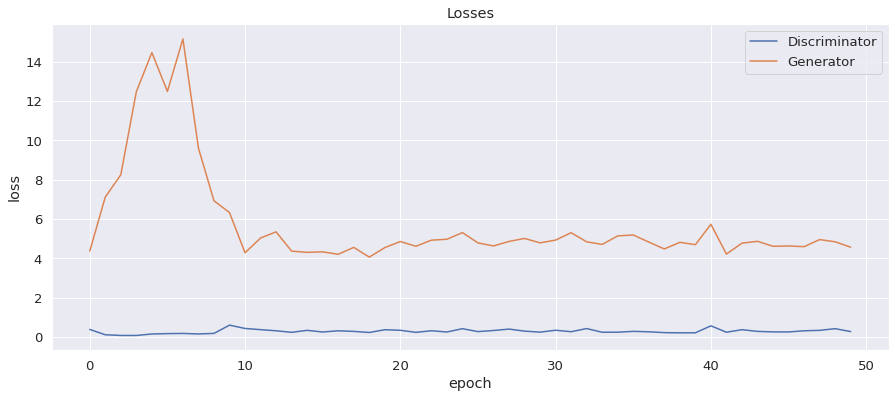

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

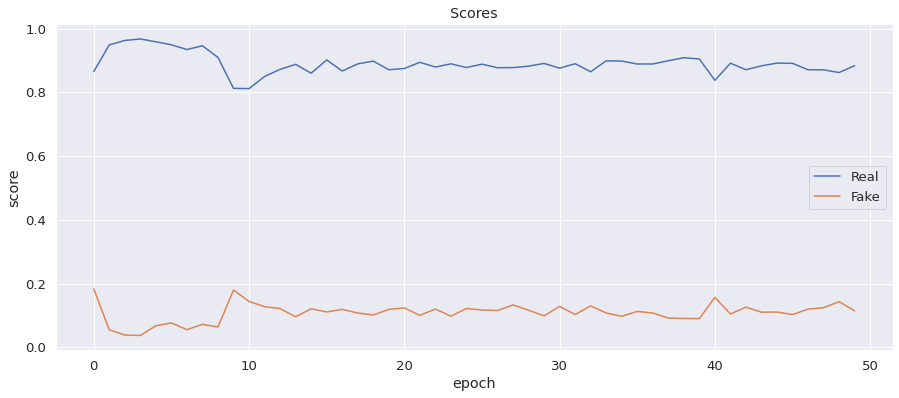

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

Лосс генератора уменьшается до 130 эпохи, затем начинает расти, лосс дискриминатора уменьшается.

Real score увеличивается, Fake score уменьшается.

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
n_images = 8
fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

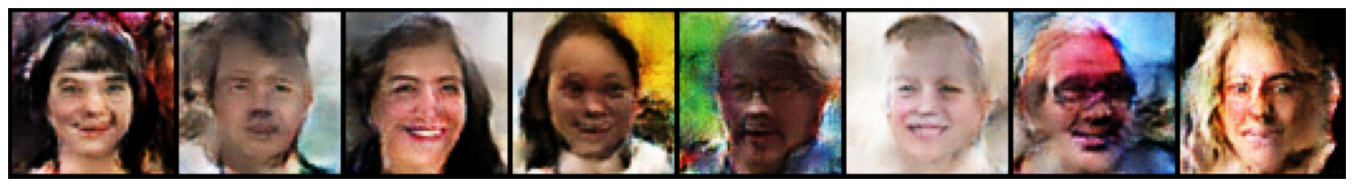

In [ ]:
def show_images(images, nmax=8):
    fig, ax = plt.subplots(figsize=(24, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.cpu().detach()[:nmax]), nrow=8).permute(1, 2, 0))

show_images(fake_images)

Как вам качество получившихся изображений? Даже после 200 эпох

Не очень :(

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut

real_images_array = None
for images, _ in train_dl:
  if real_images_array is None:
    real_images_array = images.cpu().detach().numpy().reshape((len(images), 3 * 64 *64))
  else:
    np.vstack([real_images_array, images.cpu().detach().reshape((len(images), 3 * 64 *64))])
real_images_array.shape

(128, 12288)

In [ ]:
fixed_latent = torch.randn(len(real_images_array), latent_size, 1, 1, device=device)
with torch.no_grad():
  fake_images_array = model["generator"](fixed_latent)

fake_images_array = fake_images_array.cpu().detach().numpy()
fake_images_array = fake_images_array.reshape((len(real_images_array), 3 * 64 * 64))
fake_images_array.shape

(128, 12288)

In [ ]:
X = np.vstack([real_images_array, fake_images_array])
X.shape

(256, 12288)

In [ ]:
y = np.hstack([np.zeros(len(real_images_array)), np.ones(len(fake_images_array))])
y.shape

(256,)

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=1)
loo = LeaveOneOut()

In [ ]:
positive = 0

for train_index, test_index in loo.split(X, y):
  neigh.fit(X[train_index], y[train_index])
  prediction = neigh.predict(X[test_index])
  if prediction == y[test_index]:
    positive += 1

print(positive / len(y))

0.61328125


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Нужно стремится к accuracy 0.5, т.к. в данном случае классификатор не будет различать fake и real картинки, что говорит, о хорошей работе генератора (конечно, при условии, что классификатор хороший :) ).

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
fixed_latent = torch.randn(128, latent_size, 1, 1, device=device)
fake_images = generator(fixed_latent)

fake_images = fake_images.view(-1, 12288)

real_images =  None
for images, _ in train_dl:
  real_images = images
  break
real_images = real_images.view(-1, 12288)

real = torch.ones(real_images.size(0), 1)
fake = torch.zeros(fake_images.size(0), 1)
labels = torch.cat((real, fake), 0)

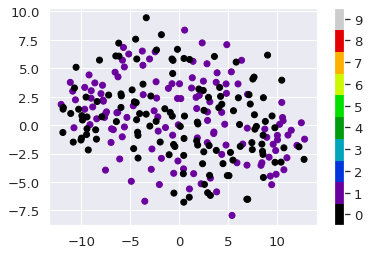

In [ ]:
from sklearn.manifold import TSNE

real_fake = torch.cat((real_images, fake_images), 0)

X_embedded = TSNE(n_components=2).fit_transform(real_fake.cpu().detach().numpy())

# plot the result
vis_x = X_embedded[:, 0]
vis_y = X_embedded[:, 1]

plt.scatter(vis_x, vis_y, c=labels, cmap=plt.cm.get_cmap("nipy_spectral", 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

Прокомментируйте получившийся результат:

Точки real и fake изображений перемешаны, что по идее говорит о хорошей работе генератора, но мне кажется, что TSNE вместе с попиксельными методами сравнения работает не очень хорошо с изображениями.

По идее нужно использовать какие-либо методы вытаскивания фич, например предообученную CNN, но времени не хватило применить этот метод.